# Imports, settings & globals

In [1]:
import sys

CODE_DIR = "/home/cbarkhof/fall-2021"

sys.path.append(CODE_DIR)
sys.path.append(f"{CODE_DIR}/analysis")
sys.path.append(f"{CODE_DIR}/analysis/bda_models")

import os

PLOT_DIR = f"{CODE_DIR}/analysis/plots/"
PLOT_DIR_BDA_PTB = f"{PLOT_DIR}/PTB_model_checks"
os.makedirs(PLOT_DIR_BDA_PTB, exist_ok=True)

In [2]:
import os
import torch
import pandas as pd
import numpy as np
from tabulate import tabulate

%config InlineBackend.figure_format='retina'
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import seaborn as sns; sns.set()
import torch.distributions as td

# c_cycler, cmap
from plot_utils import *

from datasets import load_dataset, ReadInstruction

from analysis.bda_models.bda_dp_mixture_surprisal_vals import *
# GenLDATopicModelPTB, resample_corpus, etc
from analysis.bda_models.bda_topic_model_ptb import *
from analysis_run_postprocessing.general_postprocessing_steps import make_run_overview_df

from gensim_LDA import LdaModel # I made local alterations
from gensim.models import CoherenceModel # from the gensim module

In [3]:
SAVE_DIR = "output_files"

SAVE_BDA_SURPRISAL_VALS_FILE = f"{SAVE_DIR}/topic_model_surprisal_values.pt"

SAVE_TUNING_RESULT_FILE = f"{SAVE_DIR}/topic_model_tuning_results.pt"

os.makedirs(SAVE_DIR, exist_ok=True)

In [4]:
PERFORM_HP_TUNING = False

FIT_AND_COMPUTE_SURPRISAL_VALS = True

PERFORM_MODEL_CHECKS = True

# Load overview of relevant PTB runs

In [5]:
overview_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/final_selection_runs.csv", index_col=0)
overview_df = overview_df[overview_df.image_or_language == "language"]

global_stats_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/global_stats.csv", index_col=0)
global_stats_df = global_stats_df[(global_stats_df.index.isin(overview_df.index)) \
                                  & (global_stats_df.phase == "valid")]

overview_df.head()

,objective,l_rate,dataset,image_or_language,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa,INFO-VAE,0.1,ptb,language,0.0,0,0,1,strong_distil_roberta_decoder,"(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm..."
INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa,INFO-VAE,0.1,ptb,language,0.0,0,0,10,strong_distil_roberta_decoder,"(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm..."
INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa,INFO-VAE,0.1,ptb,language,0.0,0,0,100,strong_distil_roberta_decoder,"(5-jan ptb-test) INFO-VAE[l_1_rate=0.1, l_2_mm..."
INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa,INFO-VAE,0.5,ptb,language,0.0,0,0,1,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=0.5, l_2_mmd=1...."
INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa,INFO-VAE,0.5,ptb,language,0.0,0,0,10,strong_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=0.5, l_2_mmd=10..."


# Get PTB data (train & valid)

In [6]:
if PERFORM_HP_TUNING or FIT_AND_COMPUTE_SURPRISAL_VALS or PERFORM_MODEL_CHECKS:
    # PENN TREE BANK
    ptb_train_dataset = load_dataset("ptb_text_only", ignore_verifications=True, split="train")
    ptb_train_text_samples = ptb_train_dataset["sentence"]

    ptb_valid_dataset = load_dataset("ptb_text_only", ignore_verifications=True, split="validation")
    ptb_valid_text_samples = ptb_valid_dataset["sentence"]

    print(f"Len train samples", len(ptb_train_text_samples))
    print(f"Len valid samples", len(ptb_valid_text_samples))

W0217 17:36:46.654421 22921315041024 builder.py:539] Reusing dataset ptb_text_only (/home/cbarkhof/.cache/huggingface/datasets/ptb_text_only/penn_treebank/1.1.0/8d1b97746fb9765d140e569ec5ddd35e20af4d37761f5e1bf357ea0b081f2c1f)
W0217 17:36:47.151654 22921315041024 builder.py:539] Reusing dataset ptb_text_only (/home/cbarkhof/.cache/huggingface/datasets/ptb_text_only/penn_treebank/1.1.0/8d1b97746fb9765d140e569ec5ddd35e20af4d37761f5e1bf357ea0b081f2c1f)


Len train samples 42068
Len valid samples 3370


# LDA hyper parameter tuning

In [7]:
c_dict

{'black': '#131313',
 'dark_blue': '#10277C',
 'steal_blue': '#356FB2',
 'bright_blue': '#55B9F9',
 'pink': '#F3B5E0',
 'orange': '#EE6A2C',
 'light_grey': '#E9E9E9',
 'purple': '#c0b6e2',
 'red': '#c53827',
 'light_blue': '#94c6e9'}

In [8]:
model_results = None

if not PERFORM_HP_TUNING:
    if not os.path.exists(SAVE_TUNING_RESULT_FILE):
        print("No saved tuning results to load. Set SAVE_TUNING_RESULT_FILE=True to run.")
    else:
        model_results = torch.load(SAVE_TUNING_RESULT_FILE)
else:
    # Topics range
    min_topics = 4
    max_topics = 12
    step_size = 2
    topics_range = range(min_topics, max_topics, step_size)

    # Alpha parameter
    alpha = list(np.arange(0.01, 1, 0.3)) + ["auto", "asymmetric"]

    # Beta parameter
    # beta = list(np.arange(0.01, 1, 0.3))
    # beta.append('symmetric')
    beta = ["auto"]

    # Can take a long time to run
    counter = 1
    total_exp = int(len(alpha) * len(beta) * len(topics_range))
    
    temp = GenLDATopicModelPTB(train_samples_strings=ptb_train_text_samples, preprocess_only=True)
    train_id2word = temp.dictionary
    train_docs = temp.train_docs
    train_corpus = temp.train_corpus
    valid_corpus, valid_docs = temp.lda_preprocess_transform(text_samples=ptb_valid_text_samples)

    for k in topics_range:
        for a in alpha:
            for b in beta:

                print("-"*80)
                print(f"Experiment {counter}/{total_exp}")
                print(f"K={k} alpha={a} beta={b}")

                coherence_score, log_ppl = evaluate_setting(train_corpus=train_corpus, 
                                 train_docs=train_docs, 
                                 train_id2word=train_id2word, 
                                 valid_corpus=valid_corpus, 
                                 k=k, 
                                 a=a, 
                                 b=b)

                print(f"Coherence score: {coherence_score:.2f}")
                print(f"Log perplexity: {log_ppl:.2f}")

                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence (CV)'].append(coherence_score)
                model_results['Log PPL'].append(log_ppl)

            torch.save(model_results, SAVE_TUNING_RESULT_FILE)
            counter += 1

I0217 17:36:47.240437 22921315041024 utils.py:145] Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
I0217 17:36:47.242074 22921315041024 utils.py:157] NumExpr defaulting to 8 threads.
/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


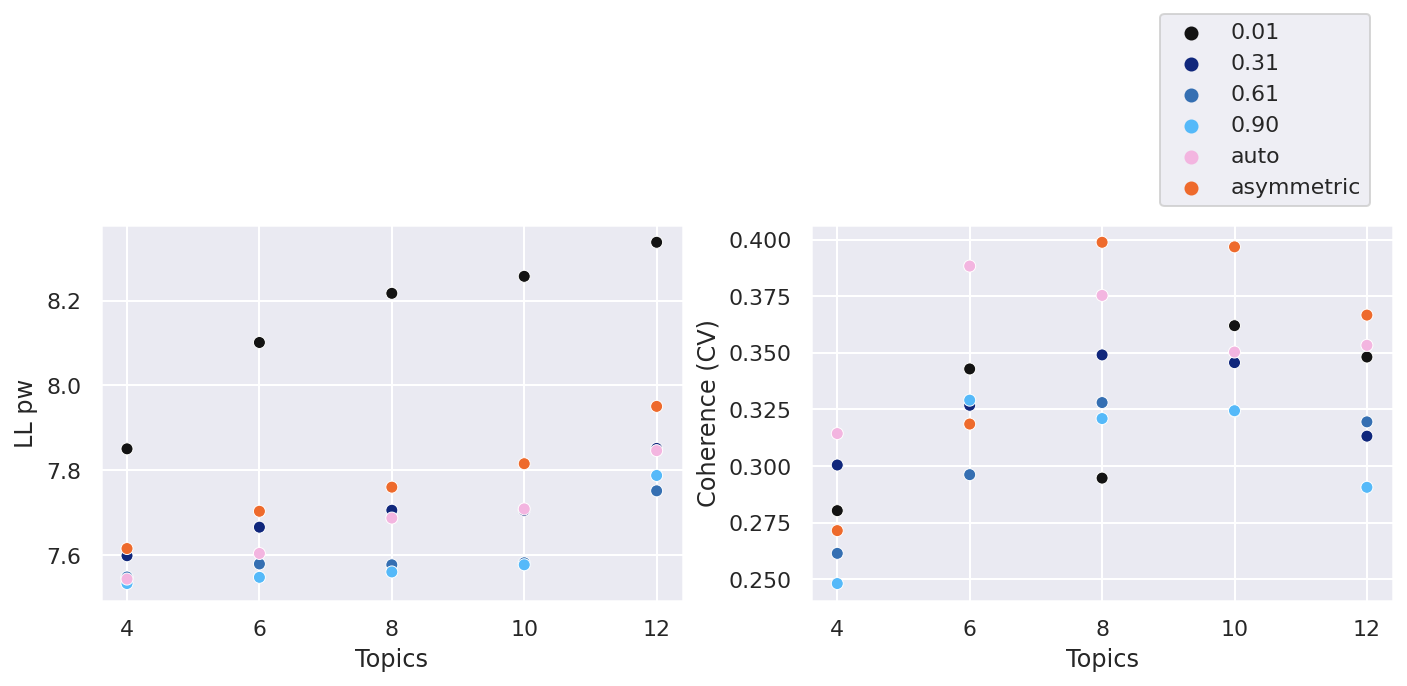

In [9]:
if model_results is not None:
    df = pd.DataFrame(model_results)

    df["LL pw"] = - df["Log PPL"]
    
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5.0))
    sns.scatterplot(data=df, x="Topics", y="LL pw", hue="Alpha", ax=axs[0], palette=list(c_dict.values())[:6])
    CV = sns.scatterplot(data=df, x="Topics", y="Coherence (CV)", hue="Alpha", ax=axs[1], palette=list(c_dict.values())[:6])

    axs[0].legend().remove()
    leg = axs[1].legend(loc=(0.6, 1.05))
    
    # to format the labels that get strange number of decimals
    for t in leg.texts:
        # truncate label text to 4 characters
        if not "a" in t.get_text():
            t.set_text(t.get_text()[:4])

plt.tight_layout()
plt.savefig(f"{PLOT_DIR_BDA_PTB}/LDA_tune_results.png", dpi=300, bbox="tight_inches")
plt.show()

In [10]:
if FIT_AND_COMPUTE_SURPRISAL_VALS:
    # Read of grid search
    ALPHA = 0.01
    BETA = "auto"
    N_TOPICS = 10

    gen_model_lda = GenLDATopicModelPTB(
        train_samples_strings=ptb_train_text_samples, 
        alpha=ALPHA,
        beta=BETA,
        num_topics=N_TOPICS, 
        chunksize=2000, 
        passes=20, 
        iterations=600, 
        eval_every=None)

I0217 17:36:52.055807 22921315041024 phrases.py:583] collecting all words and their counts
I0217 17:36:52.057980 22921315041024 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0217 17:36:52.168015 22921315041024 phrases.py:588] PROGRESS: at sentence #10000, processed 121114 words and 82407 word types
I0217 17:36:52.281660 22921315041024 phrases.py:588] PROGRESS: at sentence #20000, processed 242178 words and 144895 word types
I0217 17:36:52.401048 22921315041024 phrases.py:588] PROGRESS: at sentence #30000, processed 360298 words and 198359 word types
I0217 17:36:52.515566 22921315041024 phrases.py:588] PROGRESS: at sentence #40000, processed 479256 words and 249273 word types
I0217 17:36:52.541012 22921315041024 phrases.py:609] collected 259273 token types (unigram + bigrams) from a corpus of 503752 words and 42068 sentences
I0217 17:36:52.542585 22921315041024 phrases.py:666] merged Phrases<259273 vocab, min_count=20, threshold=10.0, max_vocab_size=40000

Number of unique tokens: 8478
Number of documents: 42068


I0217 17:39:05.310985 22921315041024 utils.py:447] LdaModel lifecycle event {'msg': 'trained LdaModel<num_terms=8478, num_topics=10, decay=0.5, chunksize=2000> in 127.34s', 'datetime': '2022-02-17T17:39:05.308767', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}


I0217 17:49:54.228457 22921315041024 phrases.py:583] collecting all words and their counts
I0217 17:49:54.230230 22921315041024 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0217 17:49:54.267468 22921315041024 phrases.py:609] collected 32676 token types (unigram + bigrams) from a corpus of 39852 words and 3370 sentences
I0217 17:49:54.268917 22921315041024 phrases.py:666] merged Phrases<32676 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0217 17:49:54.270342 22921315041024 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<32676 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.04s', 'datetime': '2022-02-17T17:49:54.270317', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}


(1000, 8478) Sample  29/ 30
(1000, 30, 8478)
8478 30
(8478, 30)


/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


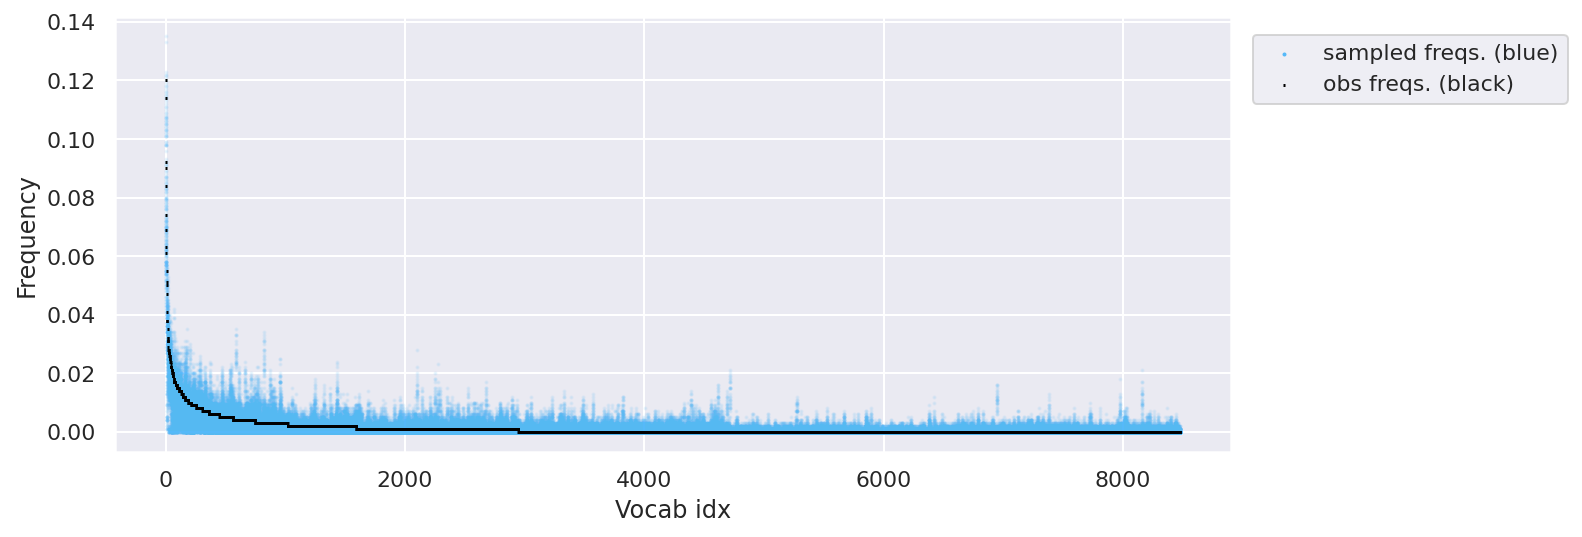

/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


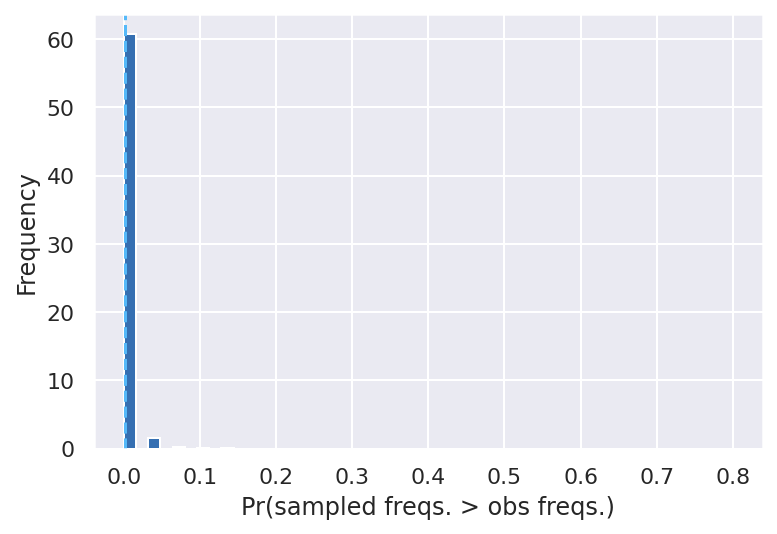

In [23]:
import torch

if FIT_AND_COMPUTE_SURPRISAL_VALS:
    if PERFORM_MODEL_CHECKS:
        # Word frequency distribution
        n_samples = 30
        topic_model = gen_model_lda.lda_model
        valid_corpus, _ = gen_model_lda.lda_preprocess_transform(text_samples=ptb_valid_text_samples)
        word_dists_orig, word_dists_resample = resample_corpus(valid_corpus, topic_model, 
                                                               n_samples=n_samples, max_docs=1000)
        
        #torch.save(dict(word_dists_orig=word_dists_orig, word_dists_resample=word_dists_resample), "lda_posterior_check_data.pt")
        plot_word_dists(word_dists_orig, word_dists_resample, save_as=f"{PLOT_DIR_BDA_PTB}/lda_word_dist_check.png")
        word_dists_orig.shape, word_dists_resample.shape

        # P value hist
        pvals = (word_dists_resample > word_dists_orig[:, None, :]).mean(axis=1)
        pvals = pvals.flatten()

        plt.hist(pvals, bins=50, density=True, color=c_dict["steal_blue"])
        plt.axvline(pvals.mean(), linestyle="--", color="#55B9F9")
        _ = plt.xlabel(f'Pr(sampled freqs. > obs freqs.)')
        _ = plt.ylabel("Frequency")
        plt.savefig(f"{PLOT_DIR_BDA_PTB}/LDA_post_check_word_dist.png", dpi=300, bbox="tight_inches")
        plt.show()

In [33]:
# Print topics
topics = gen_model_lda.lda_model.show_topics()
#topics = gen_model_lda.print_topics()

table = []
headers = ["Topic"] + [f"Token {i}" for i in range(10)]

for t_idx in range(N_TOPICS):
    top_terms = gen_model_lda.lda_model.get_topic_terms(t_idx, topn=10)
    out = [gen_model_lda.id2token[idx] for (idx, _) in top_terms]
    table.append(out)

print(tabulate(table, headers=headers))
df = pd.DataFrame(table, columns=headers[1:]).reset_index().rename({"index":"Topic"}, axis=1)
display(df)
print(df.to_latex(index=False))

Topic    Token 0    Token 1     Token 2    Token 3    Token 4    Token 5    Token 6    Token 7         Token 8
-------  ---------  ----------  ---------  ---------  ---------  ---------  ---------  --------------  ---------
market   stock      price       trading    investor   day        trader     future     index           buy
mr       say        big         dow        jones      dow_jones  one        point      world           going
test     mr         cancer      house      treatment  director   state      federal    whether         senate
million  share      year        billion    sale       earlier    quarter    company    rose            month
company  new        laboratory  operation  billion    corp       calif      loan       los             deficit
bond     rate       year        dollar     market     franc      bank       interest   billion         yield
company  inc        third       corp       president  executive  chief      co         third_quarter   unilab
new      yo

'\\begin{tabular}{rllllllllll}\n\\toprule\n Topic &  Token 0 & Token 1 &     Token 2 &    Token 3 &    Token 4 &    Token 5 &   Token 6 &   Token 7 &         Token 8 &    Token 9 \\\\\n\\midrule\n     0 &   market &   stock &       price &    trading &   investor &        day &    trader &    future &           index &        buy \\\\\n     1 &       mr &     say &         big &        dow &      jones &  dow\\_jones &       one &     point &           world &      going \\\\\n     2 &     test &      mr &      cancer &      house &  treatment &   director &     state &   federal &         whether &     senate \\\\\n     3 &  million &   share &        year &    billion &       sale &    earlier &   quarter &   company &            rose &      month \\\\\n     4 &  company &     new &  laboratory &  operation &    billion &       corp &     calif &      loan &             los &    deficit \\\\\n     5 &     bond &    rate &        year &     dollar &     market &      franc &      bank

# Load samples to evaluate surprisal of

In [11]:
MAX_MODEL_SAMPLES = 200
EXPORT_DIR = f"{CODE_DIR}/analysis_run_postprocessing/run_postprocess_files"
SAMPLE_FILE = f"generative-samples.pt"
CONDITIONAL_SAMPLE_FILE = f"generative-conditional-samples.pt"

if FIT_AND_COMPUTE_SURPRISAL_VALS:

    ptb_model_text_samples = dict()

    for i, (clean_name, row) in enumerate(overview_df.iterrows()):
        print(i, clean_name)

        save_dir = f"{EXPORT_DIR}/{row.run_name}"
        conditional_samples_file = f"{save_dir}/{CONDITIONAL_SAMPLE_FILE}"
        samples_file = f"{save_dir}/{SAMPLE_FILE}"

        cond_samples = torch.load(conditional_samples_file)["valid"]
        samples = torch.load(samples_file)

        d = {
            "conditional_original_text": cond_samples["original_input_text"][:MAX_MODEL_SAMPLES],
            "conditional_sampled_text": cond_samples["condtional_sample_text"][:MAX_MODEL_SAMPLES],
            "unconditional_sampled_text": samples["text"][:MAX_MODEL_SAMPLES]
        }

        ptb_model_text_samples[clean_name] = d

        for k, v in ptb_model_text_samples[clean_name].items():
            print(k, len(v))

        print()

    ptb_model_text_samples["data_group"] = {
        "conditional_original_text": ptb_valid_text_samples,
        "conditional_sampled_text": ptb_valid_text_samples,
        "unconditional_sampled_text": ptb_valid_text_samples
    }

0 INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

1 INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

2 INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

3 INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

4 INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

5 INFO-VAE l_Rate 0.5 l_MMD 100 dec: Strong roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

6 INFO-VAE l_Rate 1 l_MMD 1 dec: Strong roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

7 INFO-VA

# Assess surprisal of model samples under generative model

In [12]:
if FIT_AND_COMPUTE_SURPRISAL_VALS:
    gen_topic_model = gen_model_lda

    N_PERM = 100

    surprisal_values = dict()

    for idx, (clean_name, text_samples) in enumerate(ptb_model_text_samples.items()):
        print(f"{idx:2d}/{len(ptb_model_text_samples.keys())}")

        surprisal_values[clean_name] = gen_topic_model.assess_surprisal_under_model(text_samples, N_perm=N_PERM)

    torch.save(surprisal_values, SAVE_BDA_SURPRISAL_VALS_FILE)
else:
    if not os.path.exists(SAVE_BDA_SURPRISAL_VALS_FILE):
        print("No surprisal values found. You need to set FIT_AND_COMPUTE_SURPRISAL_VALS=True and run NB again.")
    else:
        surprisal_values = torch.load(SAVE_BDA_SURPRISAL_VALS_FILE)

I0210 17:01:42.835497 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:01:42.839020 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:01:42.845201 22707470126848 phrases.py:609] collected 3760 token types (unigram + bigrams) from a corpus of 2773 words and 200 sentences
I0210 17:01:42.846953 22707470126848 phrases.py:666] merged Phrases<3760 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:01:42.850097 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3760 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.02s', 'datetime': '2022-02-10T17:01:42.850066', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:01:42.875930 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:01:42.877409 

 0/24


I0210 17:01:52.322686 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:01:52.324106 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:01:52.327729 22707470126848 phrases.py:609] collected 3710 token types (unigram + bigrams) from a corpus of 2663 words and 200 sentences
I0210 17:01:52.329063 22707470126848 phrases.py:666] merged Phrases<3710 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:01:52.330412 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3710 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:01:52.330389', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:01:52.348951 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:01:52.350285 

 1/24


I0210 17:02:00.966162 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:02:00.967542 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:02:00.971131 22707470126848 phrases.py:609] collected 3658 token types (unigram + bigrams) from a corpus of 2625 words and 200 sentences
I0210 17:02:00.972468 22707470126848 phrases.py:666] merged Phrases<3658 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:02:00.973805 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3658 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:02:00.973783', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:02:00.991870 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:02:00.993208 

 2/240


I0210 17:02:09.770089 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:02:09.771481 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:02:09.775318 22707470126848 phrases.py:609] collected 3872 token types (unigram + bigrams) from a corpus of 2860 words and 200 sentences
I0210 17:02:09.776663 22707470126848 phrases.py:666] merged Phrases<3872 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:02:09.778013 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3872 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:02:09.777990', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:02:09.797767 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:02:09.799100 

 3/24


I0210 17:02:18.501106 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:02:18.502463 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:02:18.505816 22707470126848 phrases.py:609] collected 3463 token types (unigram + bigrams) from a corpus of 2496 words and 200 sentences
I0210 17:02:18.507134 22707470126848 phrases.py:666] merged Phrases<3463 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:02:18.508472 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3463 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:02:18.508452', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:02:18.525836 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:02:18.527164 

 4/240


I0210 17:02:26.831277 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:02:26.832688 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:02:26.836241 22707470126848 phrases.py:609] collected 3703 token types (unigram + bigrams) from a corpus of 2634 words and 200 sentences
I0210 17:02:26.837575 22707470126848 phrases.py:666] merged Phrases<3703 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:02:26.838914 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3703 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:02:26.838892', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}


 5/24


I0210 17:02:26.857324 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:02:26.859680 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:02:26.863163 22707470126848 phrases.py:609] collected 3820 token types (unigram + bigrams) from a corpus of 2729 words and 200 sentences
I0210 17:02:26.864497 22707470126848 phrases.py:666] merged Phrases<3820 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:02:26.865826 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3820 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:02:26.865806', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:02:26.883546 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:02:26.884920 

I0210 17:02:35.325598 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:02:35.326991 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:02:35.330494 22707470126848 phrases.py:609] collected 3595 token types (unigram + bigrams) from a corpus of 2628 words and 200 sentences
I0210 17:02:35.331832 22707470126848 phrases.py:666] merged Phrases<3595 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:02:35.333188 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3595 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:02:35.333166', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:02:35.351194 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:02:35.352528 

 6/24


I0210 17:02:43.604717 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:02:43.606090 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:02:43.609469 22707470126848 phrases.py:609] collected 3427 token types (unigram + bigrams) from a corpus of 2443 words and 200 sentences
I0210 17:02:43.610835 22707470126848 phrases.py:666] merged Phrases<3427 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:02:43.612170 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3427 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:02:43.612150', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:02:43.629091 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:02:43.630419 

 7/24


I0210 17:02:52.002294 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:02:52.004157 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:02:52.007788 22707470126848 phrases.py:609] collected 3296 token types (unigram + bigrams) from a corpus of 2379 words and 200 sentences
I0210 17:02:52.009278 22707470126848 phrases.py:666] merged Phrases<3296 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:02:52.010687 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3296 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:02:52.010664', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}


 8/24


I0210 17:02:52.027725 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:02:52.030316 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:02:52.033580 22707470126848 phrases.py:609] collected 3151 token types (unigram + bigrams) from a corpus of 2238 words and 200 sentences
I0210 17:02:52.034973 22707470126848 phrases.py:666] merged Phrases<3151 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:02:52.036335 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3151 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:02:52.036313', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:02:52.053911 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:02:52.055284 

I0210 17:03:00.182650 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:03:00.184359 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:03:00.187939 22707470126848 phrases.py:609] collected 3504 token types (unigram + bigrams) from a corpus of 2494 words and 200 sentences
I0210 17:03:00.189335 22707470126848 phrases.py:666] merged Phrases<3504 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:03:00.190704 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3504 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:03:00.190681', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:03:00.208179 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:03:00.209604 

 9/24


I0210 17:03:08.386330 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:03:08.387730 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:03:08.391194 22707470126848 phrases.py:609] collected 3546 token types (unigram + bigrams) from a corpus of 2529 words and 200 sentences
I0210 17:03:08.392529 22707470126848 phrases.py:666] merged Phrases<3546 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:03:08.393873 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3546 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:03:08.393850', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:03:08.411893 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:03:08.413230 

10/240


I0210 17:03:16.556295 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:03:16.557669 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:03:16.560929 22707470126848 phrases.py:609] collected 3295 token types (unigram + bigrams) from a corpus of 2363 words and 200 sentences
I0210 17:03:16.562260 22707470126848 phrases.py:666] merged Phrases<3295 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:03:16.563596 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3295 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:03:16.563575', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:03:16.580052 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:03:16.581389 

11/24


I0210 17:03:19.691083 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:03:19.692806 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:03:19.696366 22707470126848 phrases.py:609] collected 3309 token types (unigram + bigrams) from a corpus of 2603 words and 200 sentences
I0210 17:03:19.697706 22707470126848 phrases.py:666] merged Phrases<3309 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:03:19.699052 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3309 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:03:19.699029', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}


I0210 17:03:27.699663 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:03:27.701112 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:03:27.704634 22707470126848 phrases.py:609] collected 3585 token types (unigram + bigrams) from a corpus of 2584 words and 200 sentences
I0210 17:03:27.705965 22707470126848 phrases.py:666] merged Phrases<3585 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:03:27.707308 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3585 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:03:27.707285', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:03:27.725278 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:03:27.726614 

12/24
99/100

I0210 17:03:35.855276 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:03:35.856665 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:03:35.860140 22707470126848 phrases.py:609] collected 3524 token types (unigram + bigrams) from a corpus of 2529 words and 200 sentences
I0210 17:03:35.861472 22707470126848 phrases.py:666] merged Phrases<3524 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:03:35.862806 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3524 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:03:35.862786', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:03:35.880151 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:03:35.881556 

13/24


I0210 17:03:44.741551 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:03:44.742955 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:03:44.746570 22707470126848 phrases.py:609] collected 3735 token types (unigram + bigrams) from a corpus of 2732 words and 200 sentences
I0210 17:03:44.747902 22707470126848 phrases.py:666] merged Phrases<3735 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:03:44.749252 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3735 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:03:44.749229', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}


14/24


I0210 17:03:44.767359 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:03:44.769811 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:03:44.773223 22707470126848 phrases.py:609] collected 3545 token types (unigram + bigrams) from a corpus of 2544 words and 200 sentences
I0210 17:03:44.774544 22707470126848 phrases.py:666] merged Phrases<3545 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:03:44.775877 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3545 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:03:44.775856', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:03:44.793514 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:03:44.794850 

I0210 17:03:53.242958 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:03:53.244305 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:03:53.247678 22707470126848 phrases.py:609] collected 3469 token types (unigram + bigrams) from a corpus of 2477 words and 200 sentences
I0210 17:03:53.249000 22707470126848 phrases.py:666] merged Phrases<3469 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:03:53.250315 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3469 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:03:53.250295', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:03:53.267380 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:03:53.268700 

15/24


I0210 17:04:01.517055 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:04:01.518753 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:04:01.522422 22707470126848 phrases.py:609] collected 3582 token types (unigram + bigrams) from a corpus of 2580 words and 200 sentences
I0210 17:04:01.523760 22707470126848 phrases.py:666] merged Phrases<3582 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:04:01.525183 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3582 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:04:01.525160', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:04:01.543371 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:04:01.544759 

16/24


I0210 17:04:01.571075 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:04:01.574639 22707470126848 phrases.py:609] collected 3309 token types (unigram + bigrams) from a corpus of 2603 words and 200 sentences
I0210 17:04:01.575963 22707470126848 phrases.py:666] merged Phrases<3309 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:04:01.577353 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3309 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:04:01.577333', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}


I0210 17:04:09.602899 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:04:09.604247 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:04:09.607645 22707470126848 phrases.py:609] collected 3477 token types (unigram + bigrams) from a corpus of 2469 words and 200 sentences
I0210 17:04:09.608965 22707470126848 phrases.py:666] merged Phrases<3477 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:04:09.610277 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3477 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:04:09.610258', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:04:09.627094 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:04:09.628414 

17/24


I0210 17:04:09.631698 22707470126848 phrases.py:609] collected 3424 token types (unigram + bigrams) from a corpus of 2490 words and 200 sentences
I0210 17:04:09.634035 22707470126848 phrases.py:666] merged Phrases<3424 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:04:09.635348 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3424 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:04:09.635330', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:04:09.652515 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:04:09.653831 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:04:09.657238 22707470126848 phrases.py:609] collected 3309 token types (unigram + bigrams) from a corpus

18/240


I0210 17:04:17.777000 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:04:17.778387 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:04:17.782284 22707470126848 phrases.py:609] collected 4266 token types (unigram + bigrams) from a corpus of 3075 words and 200 sentences
I0210 17:04:17.783621 22707470126848 phrases.py:666] merged Phrases<4266 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:04:17.785014 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<4266 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:04:17.784990', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:04:17.805433 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:04:17.806785 

I0210 17:04:27.034418 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:04:27.035804 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:04:27.039399 22707470126848 phrases.py:609] collected 3548 token types (unigram + bigrams) from a corpus of 2609 words and 200 sentences
I0210 17:04:27.040742 22707470126848 phrases.py:666] merged Phrases<3548 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:04:27.042080 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3548 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:04:27.042058', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:04:27.060228 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:04:27.061650 

19/240


I0210 17:04:35.937538 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:04:35.938892 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:04:35.942292 22707470126848 phrases.py:609] collected 3594 token types (unigram + bigrams) from a corpus of 2601 words and 200 sentences
I0210 17:04:35.943617 22707470126848 phrases.py:666] merged Phrases<3594 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:04:35.944955 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3594 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:04:35.944935', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:04:35.962531 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:04:35.963860 

20/24


I0210 17:04:44.574967 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:04:44.576365 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:04:44.579936 22707470126848 phrases.py:609] collected 3676 token types (unigram + bigrams) from a corpus of 2707 words and 200 sentences
I0210 17:04:44.581271 22707470126848 phrases.py:666] merged Phrases<3676 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:04:44.582613 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3676 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:04:44.582590', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:04:44.601345 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:04:44.602679 

21/240


I0210 17:04:53.184211 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:04:53.185638 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:04:53.189131 22707470126848 phrases.py:609] collected 3708 token types (unigram + bigrams) from a corpus of 2658 words and 200 sentences
I0210 17:04:53.190456 22707470126848 phrases.py:666] merged Phrases<3708 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:04:53.191787 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<3708 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2022-02-10T17:04:53.191767', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:04:53.209614 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:04:53.210942 

22/24
23/240


I0210 17:05:02.198752 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:05:02.200350 22707470126848 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0210 17:05:02.235871 22707470126848 phrases.py:609] collected 32676 token types (unigram + bigrams) from a corpus of 39852 words and 3370 sentences
I0210 17:05:02.237259 22707470126848 phrases.py:666] merged Phrases<32676 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0210 17:05:02.238625 22707470126848 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<32676 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.04s', 'datetime': '2022-02-10T17:05:02.238601', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0210 17:05:02.482598 22707470126848 phrases.py:583] collecting all words and their counts
I0210 17:05:02.48

# Plot surprisal distribution and add global statistics

Rows: 22, cols: 3, every: 1, n_groups: 22


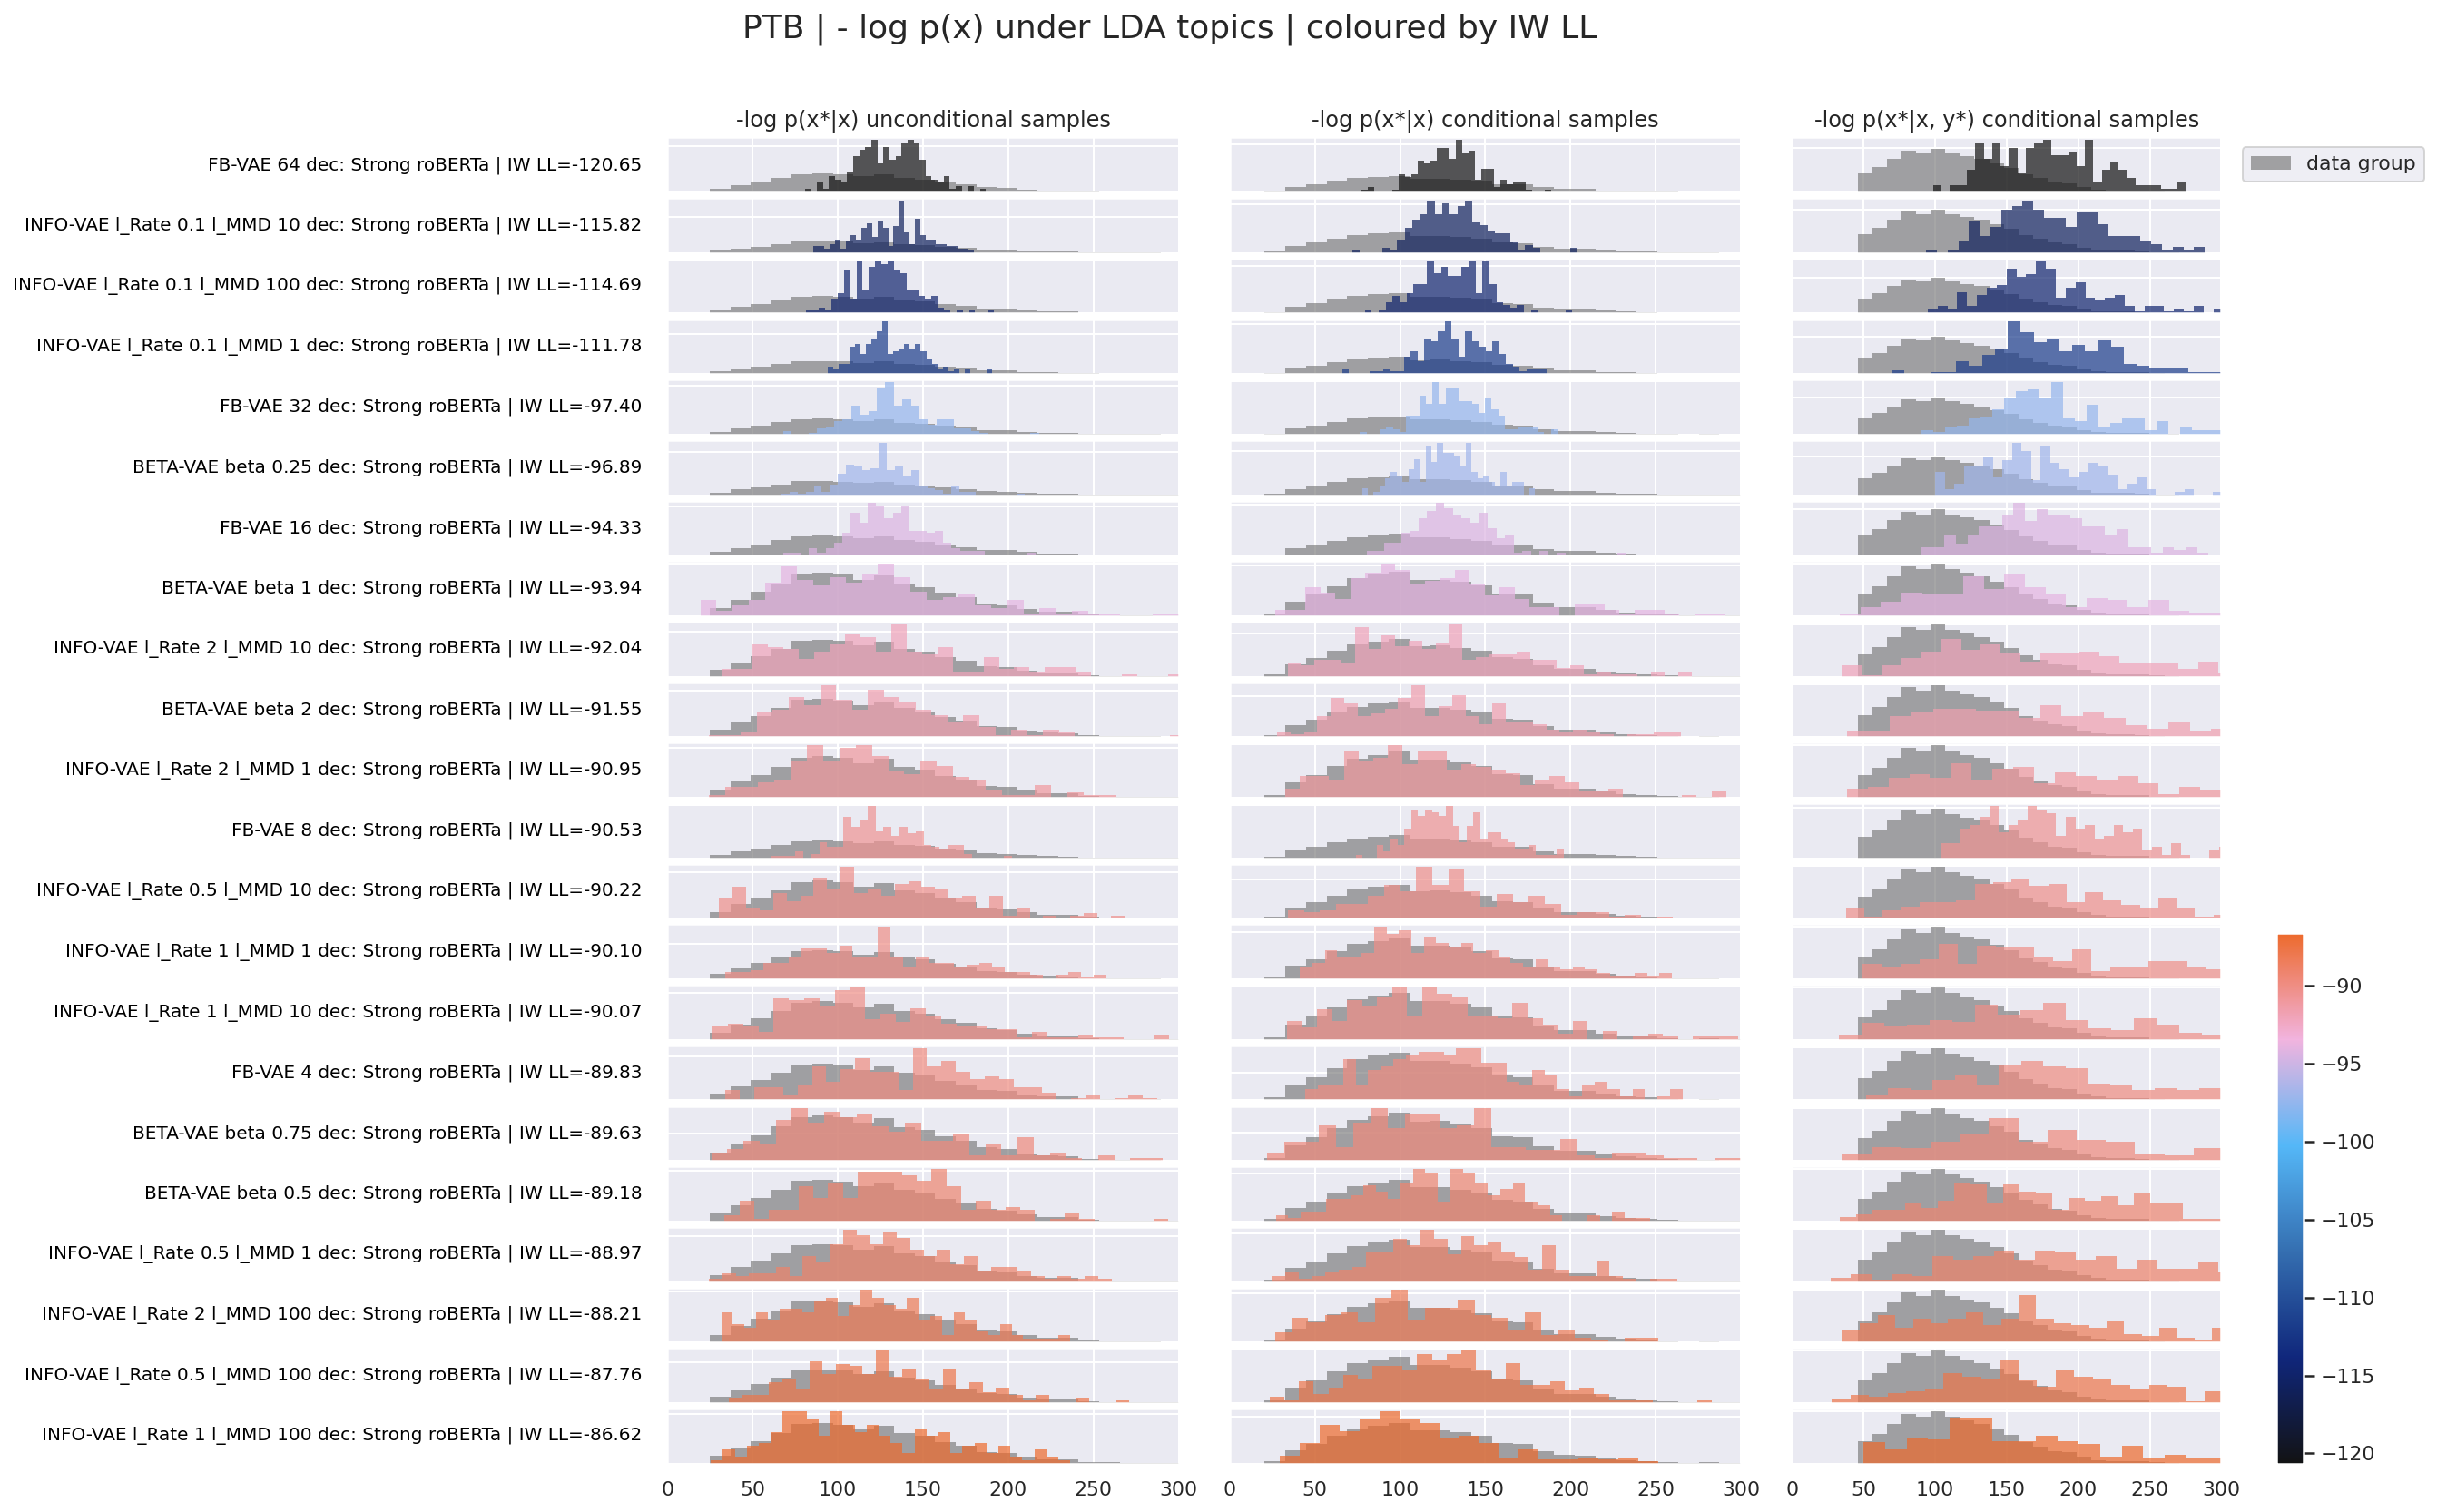

In [13]:
xlims = [[0, 300], [0, 300], [0, 300]]
ylims = [None, None, None]

global_stats_df_filter = global_stats_df[global_stats_df["IW LL"] > -250]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
                                         surprisal_values=surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="IW LL", 
                                         dataset_name="PTB",
                                         latent_structure="LDA topics",
                                         sort_name="IW LL", 
                                         cm_shrink=0.4,
#                                          cm_name="gnuplot",
                                         cmap=cmap,
                                         bins=30,
                                         title_size=18,
                                         title_y=1.05,
                                         subsample_nrows=None, 
                                         sort_ascend=True, 
                                         row_height=0.5)

Leaving out autoencoder run with high R.
Rows: 22, cols: 3, every: 1, n_groups: 22


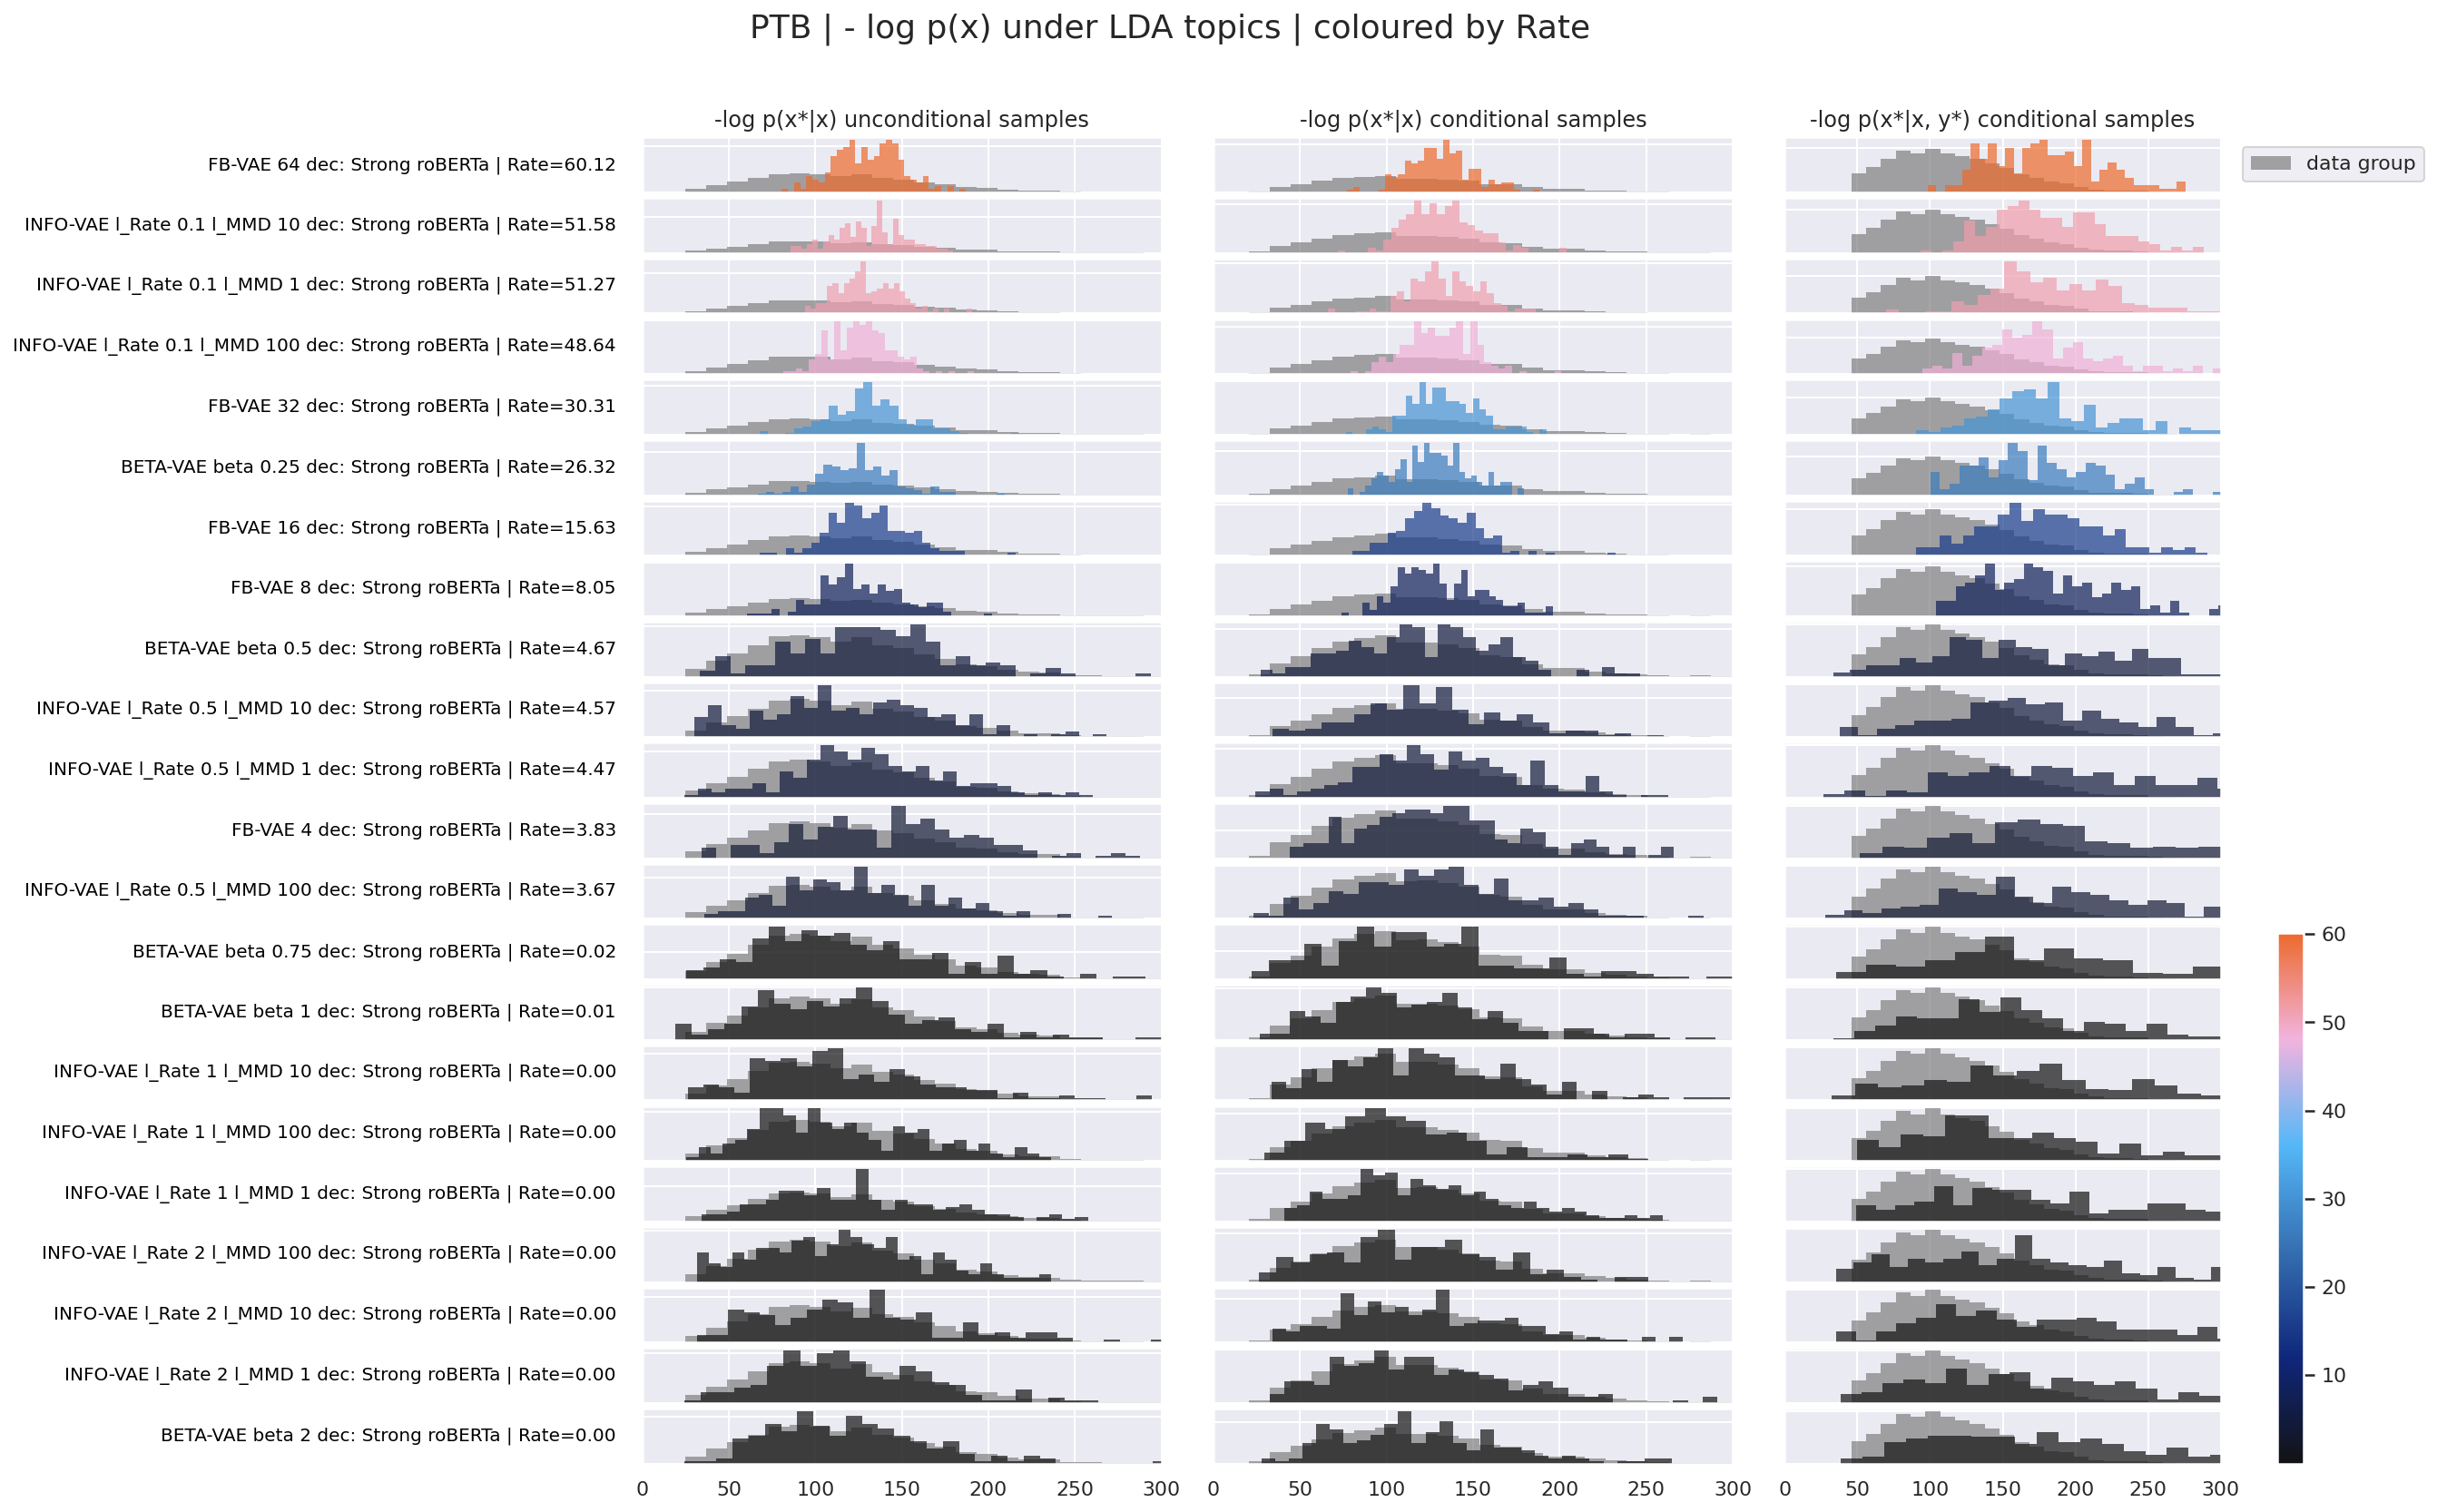

In [14]:
xlims = [[0, 300], [0, 300], [0, 300]]
ylims = [None, None, None]

global_stats_df_filter = global_stats_df[global_stats_df["kl_prior_post"] < 70]
print("Leaving out autoencoder run with high R.")

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
                                         surprisal_values=surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="kl_prior_post", 
                                         dataset_name="PTB",
                                         latent_structure="LDA topics",
                                         sort_name="Rate", 
                                         cm_shrink=0.4,
#                                          cm_name="gnuplot",
                                         cmap=cmap,
                                         bins=30,
                                         title_size=18,
                                         title_y=1.05,
                                         subsample_nrows=None, 
                                         sort_ascend=False, 
                                         row_height=0.5)